In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from datetime import date

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from os import listdir
from os.path import isfile, join

# training data
image_size = 224
labels = pd.read_csv("data/fgvc7/train.csv")
image_dir = "data/fgvc7/images"

In [2]:
# import image data and combine labels
def load_data(dataset='Train',image_dir= 'data/fgvc7/images'):
    X = []
    y = []
    for f in listdir(image_dir):
        if isfile(join(image_dir, f)) and f[:len(dataset)]==dataset:
            # add filename
            #train_list.append(f)
            # add image to the list
            img = load_img(f'{image_dir}/{f}', target_size=(image_size,image_size,3))
            img_array = img_to_array(img, dtype='uint8')
            # Get id
            id = int(f[len(dataset)+1:-4])
            X.append(img_array)
            if dataset=='Train':
                y.append(labels.iloc[id][['healthy', 'multiple_diseases', 'rust', 'scab']].to_numpy())
            else:
                y.append([f[:-4], id])
    if dataset=='Train':
        y = np.array(y, dtype=np.uint16)   
    return np.array(X, dtype=np.uint16), y

In [3]:
# import training data and combine labels
data_x, data_y  = load_data() 

## Augmentation

In [4]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.SomeOf((0,2),[
        iaa.Identity(),
        iaa.AverageBlur(k=((3, 5), (5, 7))),
        iaa.Rotate((-45,45)),
        iaa.Affine(scale=(0.5, 0.95)),    
        iaa.Multiply((0.50, 1.1))
        #,iaa.BlendAlphaRegularGrid(nb_rows=(4, 6), nb_cols=(1, 4),
        #                        foreground=iaa.Multiply(0.0))
        #,iaa.Cartoon()
        ,iaa.Cutout(nb_iterations=(1, 3), size=0.2, squared=False, cval=0)
        ,iaa.Affine(shear=(-48, 48))
        ,iaa.Affine(translate_px={"x": (-42, 42), "y": (-36, 36)})
        ,iaa.KeepSizeByResize(iaa.Resize({"height": (0.70, 0.90), "width": (0.70, 0.90)}))
        ,iaa.CropAndPad(percent=(-0.2, 0.2))
        #,iaa.PiecewiseAffine(scale=(0.01, 0.05))
        ,iaa.PerspectiveTransform(scale=(0.01, 0.1))
        #,iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
        #,iaa.ElasticTransformation(alpha=(0, 3.0), sigma=0.5)
       ])
    #,iaa.SaveDebugImageEveryNBatches(folder_path, 100)    
], random_order=True)

In [5]:
def generator(features, labels, batch_size):
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
      
        # Transform X and y
        x_aug = seq(images =features[indexes])
        yield np.array(x_aug), np.array(labels[indexes])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


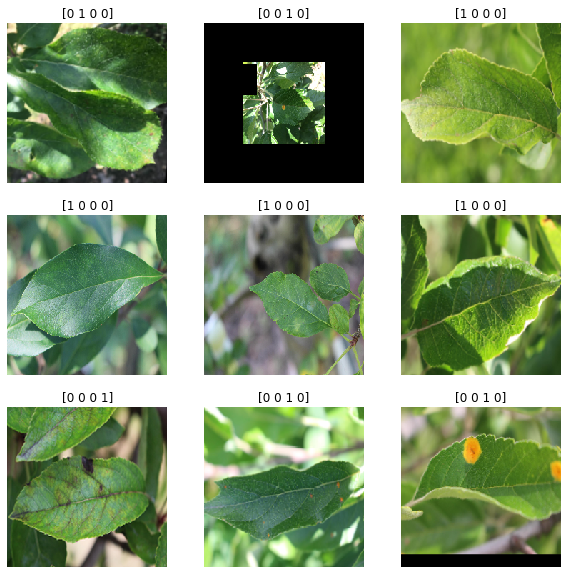

In [6]:
images = generator(data_x,data_y, 9)
image = next(images)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #augmented_image = seq(images = x_train[:1])
    plt.imshow(image[0][i])
    plt.title(str(image[1][i]))
    plt.axis("off")

## Transfer Learning

In [7]:
x_train, x_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.20, random_state=42)
y_train = np.argmax(y_train,axis=1)
y_val = np.argmax(y_val,axis=1)

In [ ]:
from tensorflow.keras import applications
import logging
logging.basicConfig(filename='EfficientNet-AutoML.log')

model_list = ['EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5'
              , 'EfficientNetB6']

for m in model_list:
    base_model = getattr(applications, m)(weights='imagenet', input_shape=(image_size, image_size, 3),  include_top=False)

    # Create new model on top.
    inputs = keras.Input(shape=(image_size, image_size, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(4)(x)
    model = keras.Model(inputs, outputs)
    model.summary()
    
    
    # Warm up head
    adam = optimizers.Adam(learning_rate=0.0005)
    #lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                               factor=0.2,  
                               patience=3, 
                               min_lr=0.00005)
    early_stop = EarlyStopping(
        monitor='val_loss', 
        min_delta=0, 
        patience=6, 
        verbose=0, 
        mode='auto',
        baseline=None, 
        restore_best_weights=True
    )

    batch_size = 64
    #num_warmup_steps = 5

    # freeze pretrained weights
    model.layers[1].trainable = False

    model.compile(optimizer=adam, 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.SparseCategoricalCrossentropy()])


    history = model.fit(generator(x_train, y_train, batch_size),  
                        shuffle=True,  
                        validation_data = (x_val, y_val),
                        callbacks = [reduce_lr,early_stop],                        
                        epochs=100,
                        steps_per_epoch=len(x_train)/batch_size ,
                        verbose=True
                       )
    print(model.optimizer.lr)
    
    # Train entire network
    adam = optimizers.Adam(learning_rate=0.0001)
    #lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                               factor=0.2,  
                               patience=5 , 
                               min_lr=0.00001)
    early_stop = EarlyStopping(
        monitor='val_accuracy', 
        min_delta=0, 
        patience=10, 
        verbose=0, 
        mode='auto',
        baseline=None, 
        restore_best_weights=True
    )

    # freeze pretrained weights
    model.layers[1].trainable = True

    model.compile(optimizer=adam, 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history2 = model.fit(generator(x_train, y_train, batch_size),  
                        shuffle=True,  
                        validation_data = (x_val, y_val),
                        callbacks = [reduce_lr,early_stop],                        
                        epochs=200,
                        steps_per_epoch=len(x_train)/batch_size ,
                        verbose=True
                       )
    model.save(f'models/{m}')
    from sklearn.metrics import confusion_matrix
    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt

    labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
    y_val_pred = np.argmax(model.predict(x_val), axis=1)
    mat = confusion_matrix(y_val, y_val_pred)

    df_cm = pd.DataFrame(mat, index = [i for i in labels],
                      columns = [i for i in labels])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    
    # Train on all data before inference
    model.fit(generator(x_val, y_val, batch_size),            
                        epochs=2,
                        steps_per_epoch=len(x_train)/batch_size ,
                        verbose=True
                       )
    
    labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
    y_val_pred = np.argmax(model.predict(x_val), axis=1)
    mat = confusion_matrix(y_val, y_val_pred)

    df_cm = pd.DataFrame(mat, index = [i for i in labels],
                      columns = [i for i in labels])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    
    # Load test data and their filename for submission file
    test_x, test_id  = load_data("Test") 
    test_y = model.predict(test_x)
    test_pred = tf.nn.softmax(test_y).numpy()
    test_set = np.hstack((test_id, test_pred))
    test_set = test_set[test_set[:,1].astype('uint16').argsort()]
    test_DF = pd.DataFrame(test_set, index=test_set[:,1], columns=["image_id","id","healthy","multiple_diseases","rust","scab"])
    test_DF[["image_id","healthy","multiple_diseases","rust","scab"]].to_csv(f'submissions/{m}.csv', index=False)
    
    file = f'submissions/{m}.csv'
    comments = f'"{m} baseline {date.today()}"'
    !kaggle competitions submit -f$file  -m$comments plant-pathology-2020-fgvc7
    
    del model
    
    
!kaggle competitions submissions plant-pathology-2020-fgvc7

16711680/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/100
22/22 [==============================] - 30s 1s/step - loss: 5.5036 - sparse_categorical_crossentropy: 5.5036 - val_loss: 1.5575 - val_sparse_categorical_crossentropy:

Epoch 34/200
22/22 [==============================] - 79s 3s/step - loss: 0.0128 - accuracy: 0.9966 - val_loss: 0.3032 - val_accuracy: 0.9370
Epoch 35/200
22/22 [==============================] - 81s 4s/step - loss: 0.0177 - accuracy: 0.9935 - val_loss: 0.3074 - val_accuracy: 0.9397
Epoch 36/200
22/22 [==============================] - 80s 4s/step - loss: 0.0238 - accuracy: 0.9894 - val_loss: 0.2855 - val_accuracy: 0.9507
Epoch 37/200
22/22 [==============================] - 81s 4s/step - loss: 0.0274 - accuracy: 0.9894 - val_loss: 0.2974 - val_accuracy: 0.9425
Epoch 38/200
22/22 [==============================] - 80s 4s/step - loss: 0.0285 - accuracy: 0.9903 - val_loss: 0.2922 - val_accuracy: 0.9370
Epoch 39/200
22/22 [==============================] - 80s 4s/step - loss: 0.0160 - accuracy: 0.9961 - val_loss: 0.2876 - val_accuracy: 0.9370
Epoch 40/200
22/22 [==============================] - 79s 3s/step - loss: 0.0158 - accuracy: 0.9953 - val_loss: 0.3017 - val_accuracy: 0.9397
Epoch 

22/22 [==============================] - 107s 5s/step - loss: 0.1216 - accuracy: 0.9674
100%|█████████████████████████████████████████| 105k/105k [00:00<00:00, 255kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7Downloading data from https://storage.googleapis.com/keras-applications/efficientnetb2_notop.h5
31793152/31790344 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, 7, 7, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 5636      
Total

22/22 [==============================] - 111s 5s/step - loss: 0.1973 - accuracy: 0.9504
Epoch 2/2
22/22 [==============================] - 110s 5s/step - loss: 0.1201 - accuracy: 0.9681
100%|█████████████████████████████████████████| 105k/105k [00:00<00:00, 163kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7Downloading data from https://storage.googleapis.com/keras-applications/efficientnetb3_notop.h5
43941888/43941136 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1536)              0         
_______________________________________

100%|█████████████████████████████████████████| 104k/104k [00:00<00:00, 229kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7Downloading data from https://storage.googleapis.com/keras-applications/efficientnetb4_notop.h5
71688192/71686520 [==============================] - 1s 0us/step
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 7, 7, 1792)        17673823  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1792)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 7172      
Total params: 17,680,995
Trainable params: 17,555,788
Non-trainable params: 125,207
_________

Epoch 2/100
22/22 [==============================] - 83s 4s/step - loss: 1.4265 - sparse_categorical_crossentropy: 1.4265 - val_loss: 1.3863 - val_sparse_categorical_crossentropy: 1.3863
Epoch 3/100
22/22 [==============================] - 83s 4s/step - loss: 1.4203 - sparse_categorical_crossentropy: 1.4203 - val_loss: 1.3863 - val_sparse_categorical_crossentropy: 1.3863
Epoch 4/100
22/22 [==============================] - 83s 4s/step - loss: 1.4059 - sparse_categorical_crossentropy: 1.4059 - val_loss: 1.3863 - val_sparse_categorical_crossentropy: 1.3863
Epoch 5/100
22/22 [==============================] - 83s 4s/step - loss: 1.3936 - sparse_categorical_crossentropy: 1.3936 - val_loss: 1.3863 - val_sparse_categorical_crossentropy: 1.3863
Epoch 6/100
22/22 [==============================] - 83s 4s/step - loss: 1.3863 - sparse_categorical_crossentropy: 1.3863 - val_loss: 1.3863 - val_sparse_categorical_crossentropy: 1.3863
Epoch 7/100
22/22 [==============================] - 83s 4s/step 

22/22 [==============================] - 109s 5s/step - loss: 1.1816 - sparse_categorical_crossentropy: 1.1816 - val_loss: 1.0780 - val_sparse_categorical_crossentropy: 1.0780
<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=5e-05>
Epoch 1/200
22/22 [==============================] - 452s 19s/step - loss: 0.7213 - accuracy: 0.7455 - val_loss: 0.2913 - val_accuracy: 0.8904
Epoch 2/200
22/22 [==============================] - 445s 20s/step - loss: 0.1877 - accuracy: 0.9359 - val_loss: 0.3045 - val_accuracy: 0.9068
Epoch 3/200
18/22 [======================>.......] - ETA: 1:34 - loss: 0.1115 - accuracy: 0.9645